In [65]:
import pandas as pd 
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LassoCV, Ridge, ElasticNetCV
from sklearn.model_selection import cross_validate, KFold, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import learning_curve
from scipy.stats import randint
import time


import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
df = pd.read_csv(r"C:\Users\alexd\Desktop\WorkSpace\NoteBook_Jupyter\Projet_DA_DST_Co2\Data_Clean\Co2_sample_v3.2.csv")

In [86]:
avg_co2 = df["Co2_Emission(WLTP)"].mean()
avg_co2

np.float64(110.51699)

In [67]:
data = df[["Constructeur","WLTP_poids","Co2_Emission(WLTP)","Type_Carburant","Puissance_KW","Fuel consumption","Pays"]]

data = data[data["Type_Carburant"] != "Electric"]

data = data[~(
    data["Type_Carburant"].isin(["Autre"])
    & (data["Co2_Emission(WLTP)"] == 0.0)
)]

scatter = data.copy()

In [68]:
data

,Constructeur,WLTP_poids,Co2_Emission(WLTP),Type_Carburant,Puissance_KW,Fuel consumption,Pays
0,SKODA,1466.0,137.0,Essence,85.0,6.0,Germany
1,RENAULT,1259.0,117.0,Essence,67.0,5.2,Slovenia
2,PEUGEOT,1526.0,144.0,Essence,96.0,6.4,Belgium
3,VOLKSWAGEN,1591.0,128.0,Diesel,110.0,4.9,Italy
4,AUDI,1654.0,138.0,Diesel,110.0,5.3,Germany
...,...,...,...,...,...,...,...
899994,VOLKSWAGEN,1365.0,129.0,Essence,85.0,5.6,France
899996,DACIA,1363.0,127.0,Essence,81.0,5.6,France
899997,DACIA,1279.0,128.0,Essence,67.0,5.6,France
899998,OPEL,1194.0,120.0,Essence,55.0,5.4,Italy


In [69]:
target = data["Co2_Emission(WLTP)"]
data = data.drop(columns="Co2_Emission(WLTP)")

                  WLTP_poids  Puissance_KW  Fuel consumption
WLTP_poids          1.000000      0.786664         -0.123391
Puissance_KW        0.786664      1.000000          0.074908
Fuel consumption   -0.123391      0.074908          1.000000


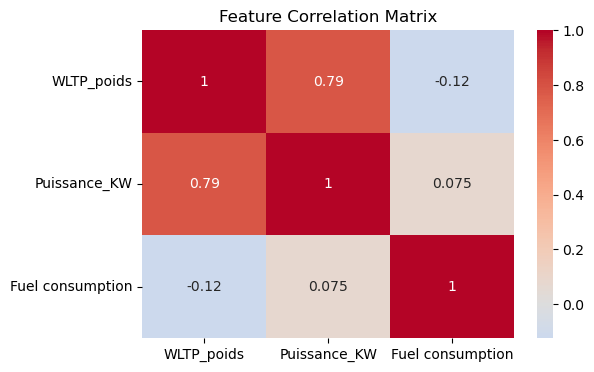

In [70]:
corr_matrix = data.corr(numeric_only=True)
print(corr_matrix)
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Feature Correlation Matrix")
plt.show()

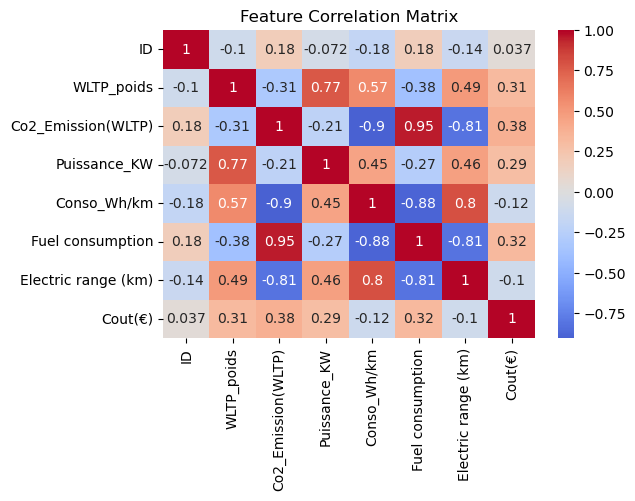

In [71]:
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Feature Correlation Matrix")

plt.show()

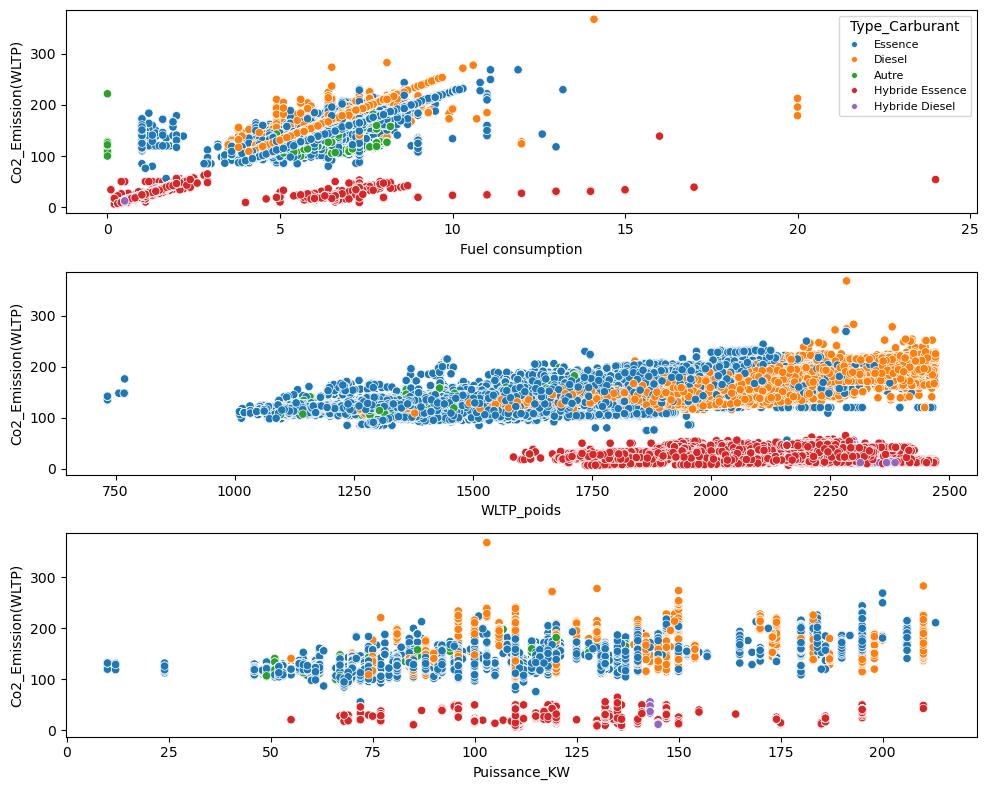

In [72]:
plt.figure(figsize=(10,8))

ax1 = plt.subplot(311)
sns.scatterplot(data=scatter, x="Fuel consumption", y="Co2_Emission(WLTP)", hue="Type_Carburant", ax=ax1)

plt.legend(
    title="Type_Carburant",
    fontsize=8,
    markerscale=0.7,
    loc="upper right"
)

ax2 = plt.subplot(312)
sns.scatterplot(data=scatter, x="WLTP_poids", y="Co2_Emission(WLTP)", hue="Type_Carburant", ax=ax2)
ax2.legend_.remove()

ax3 = plt.subplot(313)
sns.scatterplot(data=scatter, x="Puissance_KW", y="Co2_Emission(WLTP)", hue="Type_Carburant", ax=ax3)
ax3.legend_.remove()

plt.tight_layout()
plt.show()


In [73]:
%%time

num_features = make_column_selector(dtype_exclude=["category","object"])(data)
cat_features = make_column_selector(dtype_include=["category","object"])(data)

kf = KFold(n_splits = 10, shuffle=True, random_state=42)

num_prepocessor = Pipeline(
    steps = [
        ("impute",SimpleImputer(strategy="median")),
         ("scaler", StandardScaler())
    ]
)

cat_prepocessor = Pipeline(
    steps = [
         ("impute", SimpleImputer(strategy="constant", fill_value="Unknown")),
         ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessors = ColumnTransformer(
    transformers = [
        ('num',num_prepocessor, num_features),
        ('cat',cat_prepocessor, cat_features)
        
    ]
)



CPU times: total: 0 ns
Wall time: 1.56 ms


In [74]:
%%time

start = time.time()

model_LR = Pipeline(
    steps = [
        ("preprocessors", preprocessors),
        ("linreg", LinearRegression())
    ]
)

r2_scores = cross_validate(model_LR, data, target, cv = kf, scoring = "r2", return_train_score=True)
test_mean_r2 = r2_scores["test_score"].mean()
train_mean_r2 = r2_scores["train_score"].mean()

mse_scores = cross_validate(model_LR, data, target, cv = kf, scoring = "neg_mean_squared_error", return_train_score=True)
test_mean_mse = -mse_scores["test_score"].mean()
train_mean_mse = -mse_scores["train_score"].mean()


results = []

results.append({
    "model" : "LinearRegression",
    "R² - Test_score" : np.round(test_mean_r2,3),
    "R² - Train_score" : np.round(train_mean_r2,3),
    "MSE - Test_score" : np.round(test_mean_mse,3),
    "MSE - Train_score" : np.round(train_mean_mse,3),
    "time_sec": time.time() - start
    
})



CPU times: total: 17min 4s
Wall time: 4min 30s


In [133]:
df_results = pd.DataFrame(results)
df_results.sort_values("R² - Test_score", ascending=False)
df_results["RMSE"] = np.sqrt(df_results["MSE - Test_score"]).round(2) 
df_results.T

,0
model,LinearRegression
R² - Test_score,0.929
R² - Train_score,0.929
MSE - Test_score,73.461
MSE - Train_score,73.393
time_sec,270.308793
RMSE,8.57


In [75]:
model_LR

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['WLTP_poids', 'Puissance_KW',
                                                   'Fuel consumption']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Constructeur',
                                                   'Type_Carburant',
                                                   'Pays'])])),
                ('linreg', LinearRegression())])

In [77]:
y_shuffled = np.random.permutation(target)

r2_shuff = cross_val_score(model_LR, data, y_shuffled, cv=kf, scoring="r2", n_jobs=-1).mean()
print("R2 avec y mélangé :", r2_shuff)

R2 avec y mélangé : -0.00011529047304144057


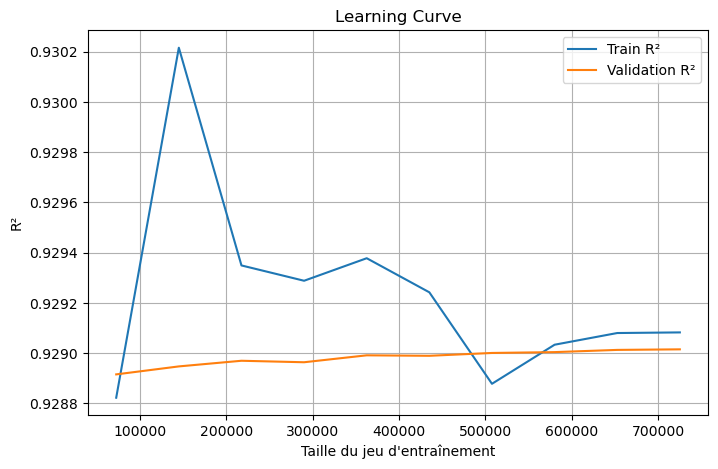

In [78]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model_LR,
    X=data,
    y=target,
    cv=kf,
    scoring="r2",
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)


train_mean = train_scores.mean(axis=1)
#train_std = train_scores.std(axis=1)

test_mean = test_scores.mean(axis=1)
#test_std = test_scores.std(axis=1)


plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, label="Train R²")
plt.plot(train_sizes, test_mean, label="Validation R²")

#plt.fill_between(train_sizes,
                 #train_mean - train_std,
                 #train_mean + train_std,
                 #alpha=0.2)

#plt.fill_between(train_sizes,
                 #test_mean - test_std,
                 #test_mean + test_std,
                 #alpha=0.2)

plt.xlabel("Taille du jeu d'entraînement")
plt.ylabel("R²")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()

In [79]:
model_clean = model_LR.fit(data,target)

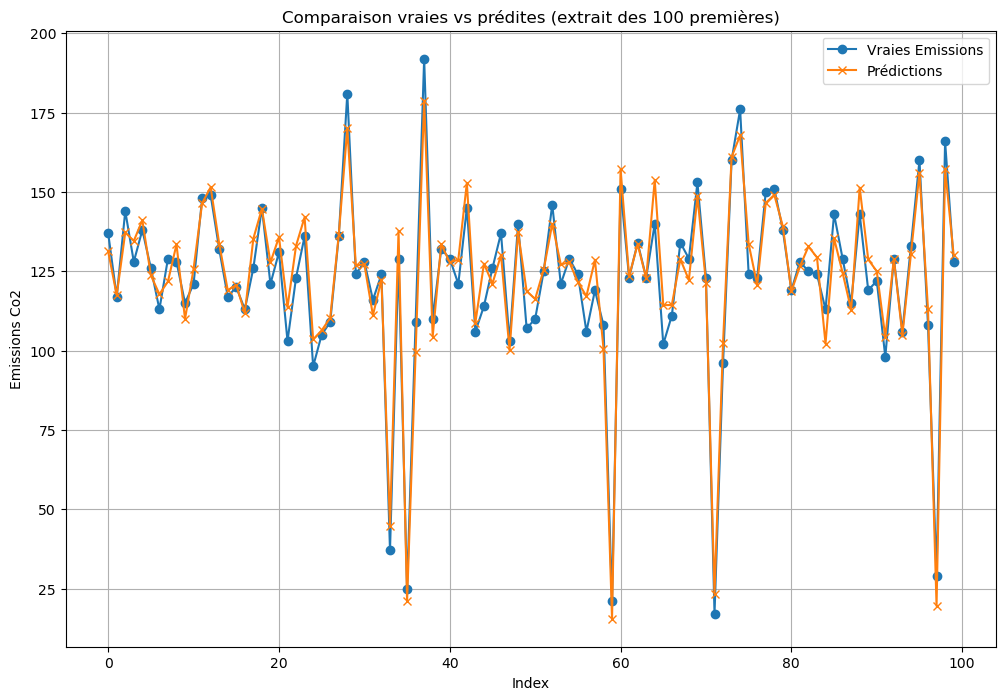

In [80]:
train_preds = model_clean.predict(data)

plt.figure(figsize=(12,8))
plt.plot(target.values[:100], label="Vraies Emissions", marker='o')
plt.plot(train_preds[:100], label="Prédictions", marker='x')
plt.legend()
plt.title("Comparaison vraies vs prédites (extrait des 100 premières)")
plt.xlabel("Index")
plt.ylabel("Emissions Co2")
plt.grid(True)
plt.legend(loc = "upper right")
plt.show()

In [113]:
prediction = train_preds - target
prediction = pd.DataFrame(prediction)
prediction["Valeurs Réelles"] = target
prediction["Prédictions"] = np.round(train_preds,3)


prediction = prediction.rename(columns = ({"Co2_Emission(WLTP)" : "Erreur"}))

prediction["Erreur"] = prediction["Erreur"].round(3)

prediction.set_index("Valeurs Réelles")


,Erreur,Prédictions
Valeurs Réelles,,
137.0,-5.723,131.277
117.0,0.468,117.468
144.0,-6.777,137.223
128.0,6.567,134.567
138.0,3.112,141.112
...,...,...
129.0,-3.444,125.556
127.0,-2.342,124.658
128.0,-6.134,121.866


In [ ]:
df_results["MAE"] = prediction["Erreur"].abs().mean().round(2) 
display(df_results.T)

,0
model,LinearRegression
R² - Test_score,0.929
R² - Train_score,0.929
MSE - Test_score,73.461
MSE - Train_score,73.393
time_sec,270.308793
RMSE,8.57
MAE,5.32


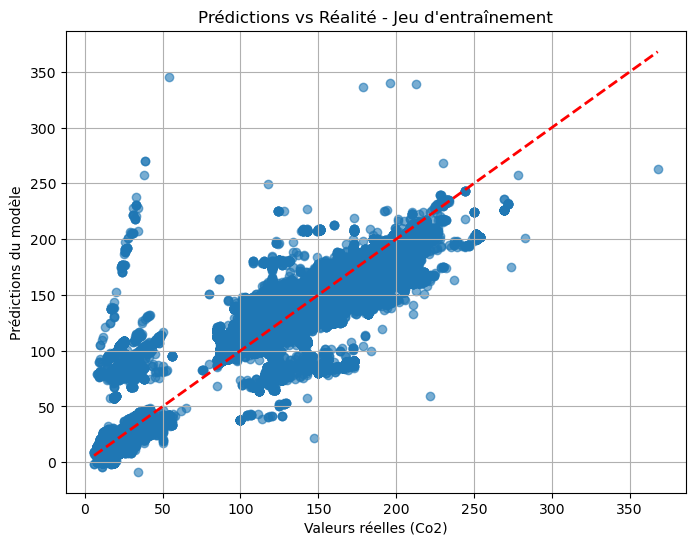

In [107]:
plt.figure(figsize=(8,6))
plt.scatter(target, train_preds, alpha=0.6)
plt.plot([target.min(), target.max()], [target.min(), target.max()], 'r--', lw=2)  
plt.xlabel("Valeurs réelles (Co2)")
plt.ylabel("Prédictions du modèle")
plt.title("Prédictions vs Réalité - Jeu d'entraînement")
plt.grid(True)
plt.show()

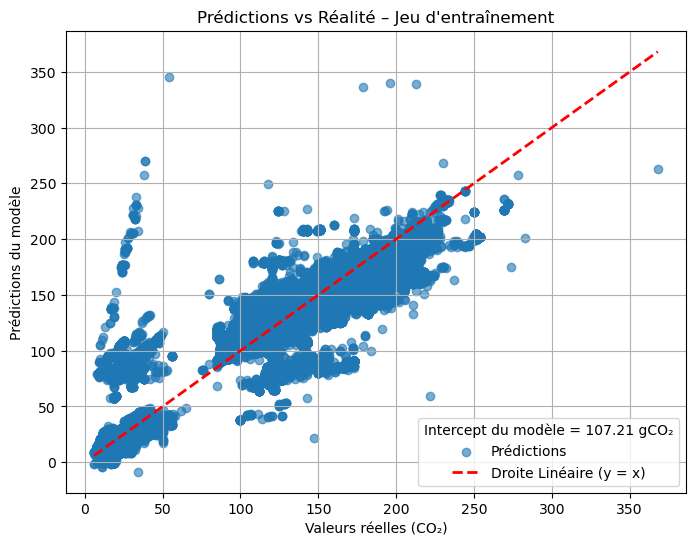

In [108]:
intercept = model_clean.named_steps["linreg"].intercept_


plt.figure(figsize=(8,6))

plt.scatter(
    target,
    train_preds,
    alpha=0.6,
    label="Prédictions"
)

plt.plot(
    [target.min(), target.max()],
    [target.min(), target.max()],
    'r--',
    lw=2,
    label=f"Droite Linéaire (y = x)"
)

plt.xlabel("Valeurs réelles (CO₂)")
plt.ylabel("Prédictions du modèle")
plt.title("Prédictions vs Réalité – Jeu d'entraînement")

plt.legend(+
    title=f"Intercept du modèle = {intercept:.2f} gCO₂"
)


plt.grid(True)
plt.show()


In [83]:
resultat_lr = model_clean.named_steps["linreg"]

print(resultat_lr.intercept_)

107.21023182080953


In [89]:
feature_names = model_clean.named_steps["preprocessors"].get_feature_names_out()

coefficients = pd.DataFrame({
    "Variable": feature_names,
    "Coefficient": resultat_lr.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

coefficients


,Variable,Coefficient
71,cat__Type_Carburant_Hybride Diesel,-40.642494
69,cat__Type_Carburant_Diesel,35.932281
67,cat__Constructeur_WEY,34.966471
72,cat__Type_Carburant_Hybride Essence,-33.406769
40,cat__Constructeur_MAN,32.452094
...,...,...
90,cat__Pays_Luxembourg,0.460944
73,cat__Pays_Austria,0.361639
87,cat__Pays_Italy,0.284291
76,cat__Pays_Croatia,0.162215


In [85]:
feature_names = model_clean.named_steps["preprocessors"].get_feature_names_out()
coefs = model_clean.named_steps["linreg"].coef_

coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})

coef_df["variables"] = (
    coef_df["feature"]
    .str.replace(r"^(num|cat)__", "", regex=True)   
    .str.split("_").str[0]                          
)

group_importance = (coef_df.groupby("variables")["coef"]
                    .apply(lambda s: np.sqrt(np.sum(s**2)))
                    .sort_values(ascending=False))

rename_map = {
    "Type": "Type Carburant",
    "WLTP": "WLTP_poids",
    "Puissance": "Puissance_KW"
}

group_importance = group_importance.rename(index=rename_map)
group_importance

variables
Constructeur        95.322962
Type Carburant      69.960133
Pays                44.778771
Fuel consumption    17.753524
WLTP_poids           4.315333
Puissance_KW         3.278277
Name: coef, dtype: float64